In [1]:
# Check updated synthetic data date range
import pandas as pd
from datetime import datetime

# Load the fresh data
interactions = pd.read_csv('../data/raw/synth/customer_interactions.csv')
interactions['month'] = pd.to_datetime(interactions['month'])

# Current date for comparison
current_date = datetime.now()
print(f"Current date: {current_date.strftime('%Y-%m')}")
print(f"Analysis run on: {current_date}")
print()

# Date range analysis
print("=== UPDATED DATA DATE ANALYSIS ===")
print(f"Earliest date: {interactions['month'].min().strftime('%Y-%m')}")
print(f"Latest date: {interactions['month'].max().strftime('%Y-%m')}")
print()

# Year breakdown  
year_counts = interactions['month'].dt.year.value_counts().sort_index()
print("Records by year:")
for year, count in year_counts.items():
    print(f"{year}: {count:,} records")

print()
# Check if data is current
latest_year = interactions['month'].dt.year.max()
current_year = current_date.year

if latest_year >= current_year:
    print("DATA IS CURRENT!")
    print(f"Data extends through {latest_year}, current year is {current_year}")
else:
    print("DATA IS OUTDATED!")
    print(f"Latest data year: {latest_year}, current year: {current_year}")

print()
print(f"Total interactions: {len(interactions):,}")
print(f"Date range span: {(interactions['month'].max() - interactions['month'].min()).days} days")

# Check for 2024 and 2025 data specifically
data_2024 = interactions[interactions['month'].dt.year == 2024]
data_2025 = interactions[interactions['month'].dt.year == 2025]
print(f"\n2024 records: {len(data_2024):,}")
print(f"2025 records: {len(data_2025):,}")

if len(data_2024) > 0 and len(data_2025) > 0:
    print("Data now includes both 2024 and 2025! Problem solved!")
else:
    print("Still missing recent data")

Current date: 2025-09
Analysis run on: 2025-09-01 18:56:37.679848

=== UPDATED DATA DATE ANALYSIS ===
Earliest date: 2021-01
Latest date: 2025-07

Records by year:
2021: 13,479 records
2022: 39,371 records
2023: 64,226 records
2024: 89,724 records
2025: 63,968 records

DATA IS CURRENT!
Data extends through 2025, current year is 2025

Total interactions: 270,768
Date range span: 1642 days

2024 records: 89,724
2025 records: 63,968
Data now includes both 2024 and 2025! Problem solved!


In [2]:
# Check the actual date range in the data
print("=== CURRENT DATA DATE ANALYSIS ===")
print(f"Interactions data shape: {interactions.shape}")
print(f"\nDate range in data:")
print(f"Earliest date: {interactions['month'].min()}")
print(f"Latest date: {interactions['month'].max()}")

# Convert to datetime for better analysis
interactions['month_dt'] = pd.to_datetime(interactions['month'])
print(f"\nActual date range:")
print(f"From: {interactions['month_dt'].min().strftime('%B %Y')}")
print(f"To: {interactions['month_dt'].max().strftime('%B %Y')}")

# Check 2024 and 2025 data
data_2024 = interactions[interactions['month_dt'].dt.year == 2024]
data_2025 = interactions[interactions['month_dt'].dt.year == 2025]

print(f"\nYear breakdown:")
year_counts = interactions['month_dt'].dt.year.value_counts().sort_index()
for year, count in year_counts.items():
    print(f"  {year}: {count:,} records")

print(f"\nMissing recent data:")
print(f"  2024 records: {len(data_2024):,}")
print(f"  2025 records: {len(data_2025):,}")

if len(data_2024) == 0:
    print(f"\nDATA IS OUTDATED! No 2024 data found.")
    print(f"Current date: September 2025")
    print(f"Data needs to be updated to include 2024-2025!")

=== CURRENT DATA DATE ANALYSIS ===
Interactions data shape: (270768, 15)

Date range in data:
Earliest date: 2021-01-01 00:00:00
Latest date: 2025-07-01 00:00:00

Actual date range:
From: January 2021
To: July 2025

Year breakdown:
  2021: 13,479 records
  2022: 39,371 records
  2023: 64,226 records
  2024: 89,724 records
  2025: 63,968 records

Missing recent data:
  2024 records: 89,724
  2025 records: 63,968


# Basketball Fan Retention - Data Exploration

This notebook explores the synthetic basketball fan data to understand customer segments, engagement patterns, and team performance relationships.

## Contents
1. Data Loading and Setup
2. Customer Data Exploration
3. Team Performance Analysis
4. Customer Interaction Patterns
5. Churn Analysis
6. Data Quality Assessment

In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Add src to path for imports
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent / "src"))

from config import get_data_paths, load_config

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Loading and Setup

In [4]:
# Load configuration
config = load_config()
data_paths = get_data_paths()

print("Configuration loaded:")
synthetic_config = config['data']['synthetic']
print(f"Synthetic customers: {synthetic_config['n_customers']}")
print(f"Date range: {synthetic_config['date_range']['start']} to {synthetic_config['date_range']['end']}")
print(f"Customer segments: {list(synthetic_config['segments'].keys())}")

print(f"\nData paths configured:")
for key, path in data_paths.items():
    print(f"  {key}: {path}")

Configuration loaded:
Synthetic customers: 10000
Date range: 2021-01-01 to 2025-09-01
Customer segments: ['casual', 'regular', 'avid', 'super_fan']

Data paths configured:
  raw_api: c:\Users\tifek\GitHub\basketball_fan_retention\data\raw\api
  raw_bbref: c:\Users\tifek\GitHub\basketball_fan_retention\data\raw\bbref
  raw_synth: c:\Users\tifek\GitHub\basketball_fan_retention\data\raw\synth
  processed_models: c:\Users\tifek\GitHub\basketball_fan_retention\data\processed\models
  processed_figures: c:\Users\tifek\GitHub\basketball_fan_retention\data\processed\figures
  processed_ltv: c:\Users\tifek\GitHub\basketball_fan_retention\data\processed\ltv
  processed_assignments: c:\Users\tifek\GitHub\basketball_fan_retention\data\processed\assignments


In [5]:
# Load synthetic data
try:
    customers_df = pd.read_csv(data_paths['raw_synth'] / 'customers.csv')
    interactions_df = pd.read_csv(data_paths['raw_synth'] / 'customer_interactions.csv')
    team_performance_df = pd.read_csv(data_paths['raw_synth'] / 'team_performance.csv')
    
    print("Data loaded successfully!")
    print(f"Customers: {len(customers_df):,} records")
    print(f"Interactions: {len(interactions_df):,} records")
    print(f"Team Performance: {len(team_performance_df):,} records")
    
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please run the synthetic data generation script first:")
    print("python scripts/generate_synthetic_data.py")

Data loaded successfully!
Customers: 10,000 records
Interactions: 270,768 records
Team Performance: 1,680 records


## 2. Customer Data Exploration

In [6]:
# Customer data overview
print("Customer Data Overview:")
print(customers_df.info())
print("\nFirst few rows:")
display(customers_df.head())

Customer Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_id           10000 non-null  object 
 1   segment               10000 non-null  object 
 2   plan_tier             10000 non-null  object 
 3   price                 10000 non-null  float64
 4   signup_date           10000 non-null  object 
 5   auto_renew            10000 non-null  bool   
 6   initial_discount      10000 non-null  float64
 7   age_group             10000 non-null  object 
 8   region                10000 non-null  object 
 9   favorite_team         10000 non-null  object 
 10  years_following_team  10000 non-null  int64  
 11  team_loyalty_score    10000 non-null  float64
dtypes: bool(1), float64(3), int64(1), object(7)
memory usage: 869.3+ KB
None

First few rows:


,customer_id,segment,plan_tier,price,signup_date,auto_renew,initial_discount,age_group,region,favorite_team,years_following_team,team_loyalty_score
0,CUST_000001,casual,basic,14.22,2021-03-29,True,0.0,65+,southwest,HOU,5,0.24
1,CUST_000002,super_fan,vip,109.63,2025-05-04,True,0.0,18-24,west,GSW,9,0.62
2,CUST_000003,super_fan,vip,205.83,2024-02-29,True,0.0,25-34,northeast,PHI,6,0.81
3,CUST_000004,regular,premium,44.79,2022-05-24,True,0.0,25-34,northeast,PHI,8,0.59
4,CUST_000005,casual,basic,40.24,2022-12-31,True,0.0,45-54,southeast,ORL,9,0.24


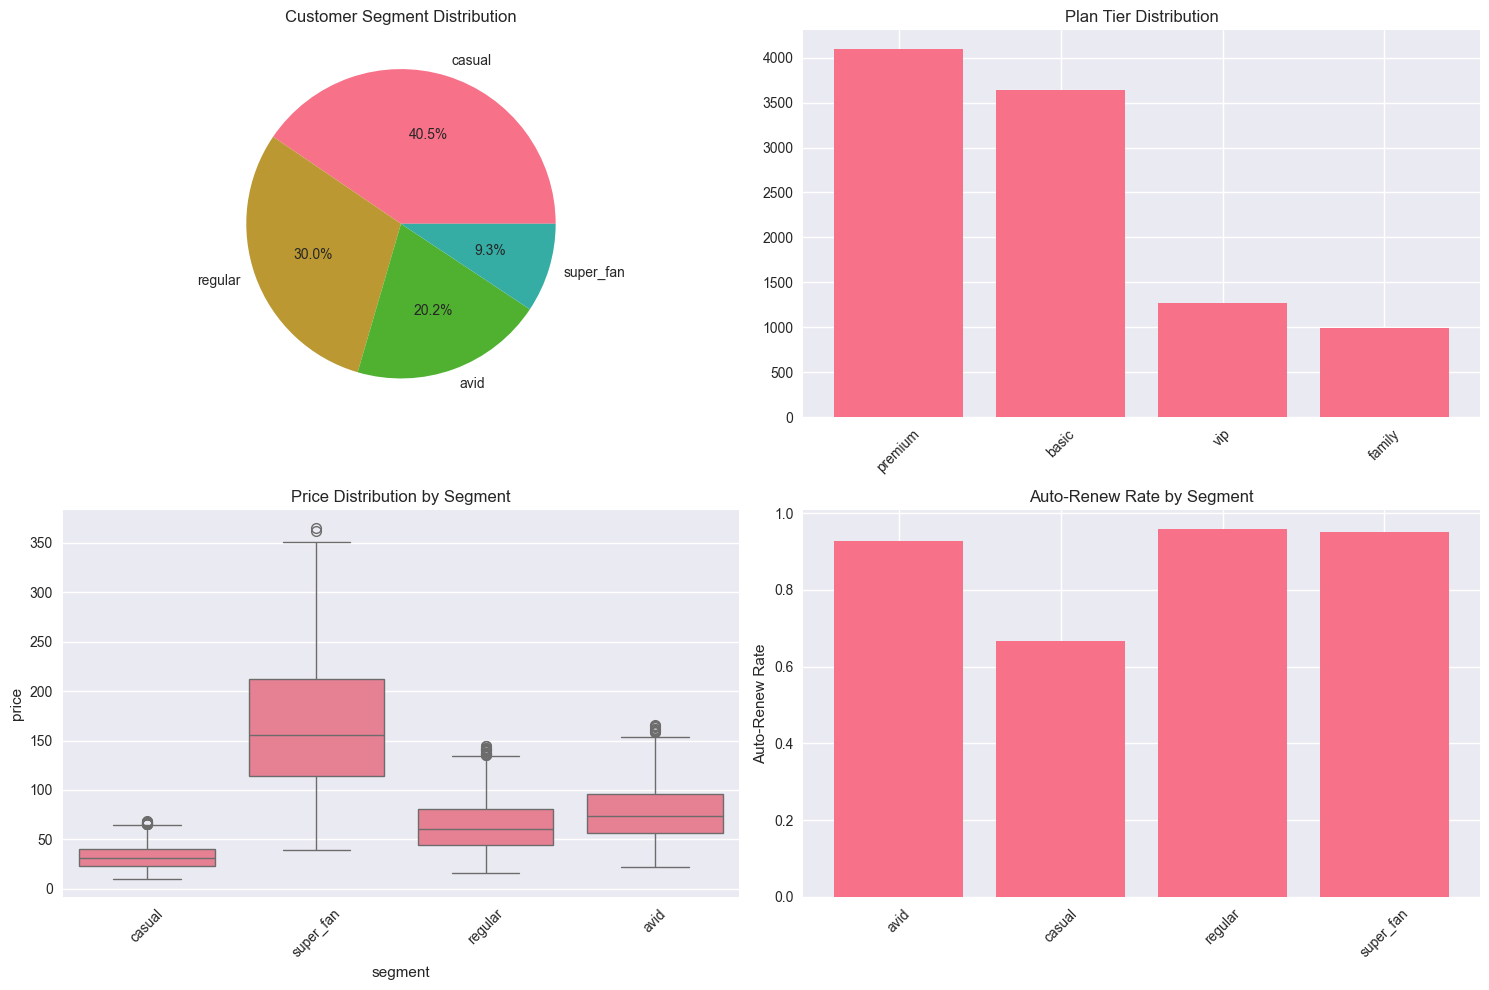

In [7]:
# Customer segment distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Segment distribution
segment_counts = customers_df['segment'].value_counts()
axes[0,0].pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%')
axes[0,0].set_title('Customer Segment Distribution')

# Plan tier distribution
plan_counts = customers_df['plan_tier'].value_counts()
axes[0,1].bar(plan_counts.index, plan_counts.values)
axes[0,1].set_title('Plan Tier Distribution')
axes[0,1].tick_params(axis='x', rotation=45)

# Price distribution by segment
sns.boxplot(data=customers_df, x='segment', y='price', ax=axes[1,0])
axes[1,0].set_title('Price Distribution by Segment')
axes[1,0].tick_params(axis='x', rotation=45)

# Auto-renew by segment
auto_renew_by_segment = customers_df.groupby('segment')['auto_renew'].mean()
axes[1,1].bar(auto_renew_by_segment.index, auto_renew_by_segment.values)
axes[1,1].set_title('Auto-Renew Rate by Segment')
axes[1,1].set_ylabel('Auto-Renew Rate')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 3. Team Performance Analysis

In [8]:
# Team performance overview
print("Team Performance Data Overview:")
print(team_performance_df.info())
print("\nSummary Statistics:")
display(team_performance_df.describe())

Team Performance Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1680 entries, 0 to 1679
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   team                      1680 non-null   object 
 1   month                     1680 non-null   object 
 2   win_rate                  1680 non-null   float64
 3   avg_point_differential    1680 non-null   float64
 4   games_played              1680 non-null   int64  
 5   attendance_percentage     1680 non-null   float64
 6   back_to_back_games        1680 non-null   int64  
 7   star_player_games_missed  1680 non-null   int64  
 8   is_playoff_month          1680 non-null   bool   
 9   home_advantage            1680 non-null   float64
dtypes: bool(1), float64(4), int64(3), object(2)
memory usage: 119.9+ KB
None

Summary Statistics:


,win_rate,avg_point_differential,games_played,attendance_percentage,back_to_back_games,star_player_games_missed,home_advantage
count,1680.000000,1680.000000,1680.00000,1680.000000,1680.000000,1680.000000,1680.000000
mean,0.517016,0.263929,7.65119,0.772118,0.913095,0.475000,0.055333
std,0.268254,7.371605,6.06524,0.152047,1.352498,0.986795,0.021229
min,0.000000,-20.600000,0.00000,0.300000,0.000000,0.000000,0.013000
25%,0.352750,-4.400000,0.00000,0.674000,0.000000,0.000000,0.043000
50%,0.568000,1.300000,10.00000,0.788000,0.000000,0.000000,0.060000
75%,0.725250,5.625000,13.00000,0.890000,2.000000,0.000000,0.066000
max,1.000000,20.600000,16.00000,1.000000,6.000000,6.000000,0.096000


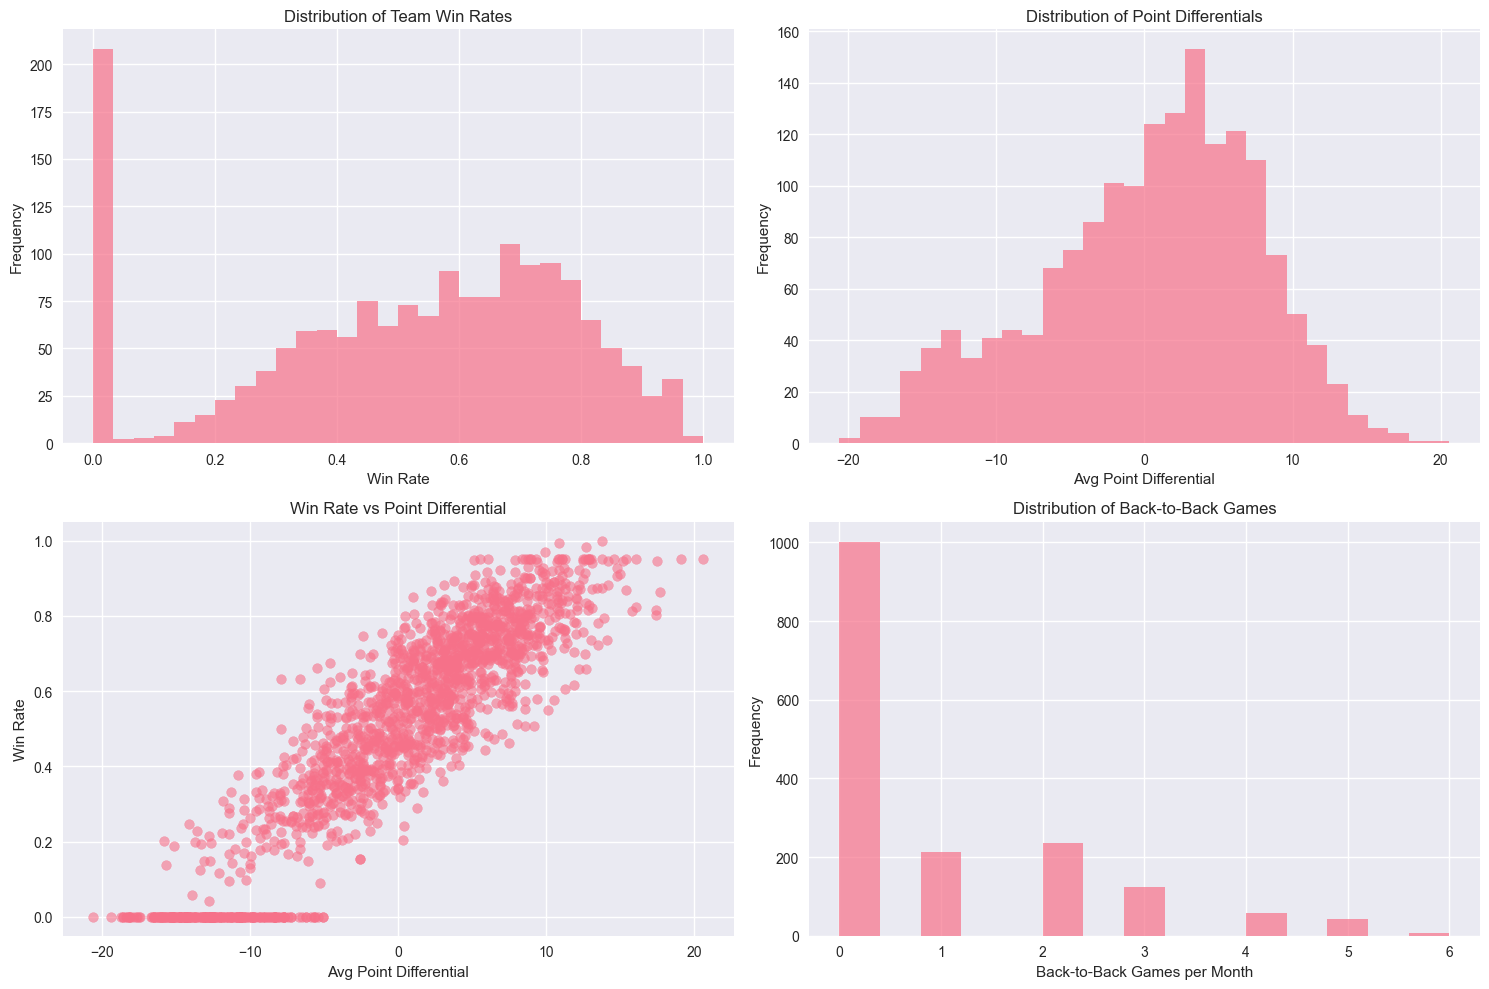

In [9]:
# Team performance visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Win rate distribution
axes[0,0].hist(team_performance_df['win_rate'], bins=30, alpha=0.7)
axes[0,0].set_title('Distribution of Team Win Rates')
axes[0,0].set_xlabel('Win Rate')
axes[0,0].set_ylabel('Frequency')

# Point differential distribution
axes[0,1].hist(team_performance_df['avg_point_differential'], bins=30, alpha=0.7)
axes[0,1].set_title('Distribution of Point Differentials')
axes[0,1].set_xlabel('Avg Point Differential')
axes[0,1].set_ylabel('Frequency')

# Win rate vs point differential
axes[1,0].scatter(team_performance_df['avg_point_differential'], 
                  team_performance_df['win_rate'], alpha=0.6)
axes[1,0].set_title('Win Rate vs Point Differential')
axes[1,0].set_xlabel('Avg Point Differential')
axes[1,0].set_ylabel('Win Rate')

# Back-to-back games distribution
axes[1,1].hist(team_performance_df['back_to_back_games'], bins=15, alpha=0.7)
axes[1,1].set_title('Distribution of Back-to-Back Games')
axes[1,1].set_xlabel('Back-to-Back Games per Month')
axes[1,1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 4. Customer Interaction Patterns

In [10]:
# Interaction data overview
print("Interaction Data Overview:")
print(interactions_df.info())
print("\nSummary Statistics:")
display(interactions_df.describe())

Interaction Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270768 entries, 0 to 270767
Data columns (total 15 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   customer_id                270768 non-null  object 
 1   month                      270768 non-null  object 
 2   minutes_watched            270768 non-null  int64  
 3   tickets_purchased          270768 non-null  int64  
 4   games_attended             270768 non-null  int64  
 5   merch_spend                270768 non-null  float64
 6   support_tickets            270768 non-null  int64  
 7   app_logins                 270768 non-null  int64  
 8   social_media_interactions  270768 non-null  int64  
 9   promo_exposure             270768 non-null  int64  
 10  email_opens                270768 non-null  int64  
 11  engagement_level           270768 non-null  float64
 12  team_win_rate              270768 non-null  float64
 13  is

,minutes_watched,tickets_purchased,games_attended,merch_spend,support_tickets,app_logins,social_media_interactions,promo_exposure,email_opens,engagement_level,team_win_rate
count,270768.000000,270768.000000,270768.000000,270768.000000,270768.000000,270768.000000,270768.000000,270768.000000,270768.000000,270768.000000,270768.000000
mean,153.509831,0.101419,0.035602,68.659589,0.011955,1.664473,0.894397,1.480555,1.600100,0.233719,0.563933
std,299.985697,0.370219,0.240589,159.769724,0.111202,2.731624,1.567213,1.784910,2.240592,0.265309,0.261881
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.413000
50%,41.000000,0.000000,0.000000,10.650000,0.000000,0.000000,0.000000,1.000000,1.000000,0.161000,0.625000
75%,178.000000,0.000000,0.000000,68.950000,0.000000,2.000000,1.000000,3.000000,3.000000,0.383000,0.762000
max,8496.000000,7.000000,6.000000,6918.220000,2.000000,26.000000,17.000000,14.000000,19.000000,1.000000,1.000000


In [11]:
# Merge interactions with customer data for segment analysis
interactions_with_segments = interactions_df.merge(
    customers_df[['customer_id', 'segment', 'plan_tier']], 
    on='customer_id'
)

print(f"Merged dataset shape: {interactions_with_segments.shape}")

Merged dataset shape: (270768, 17)


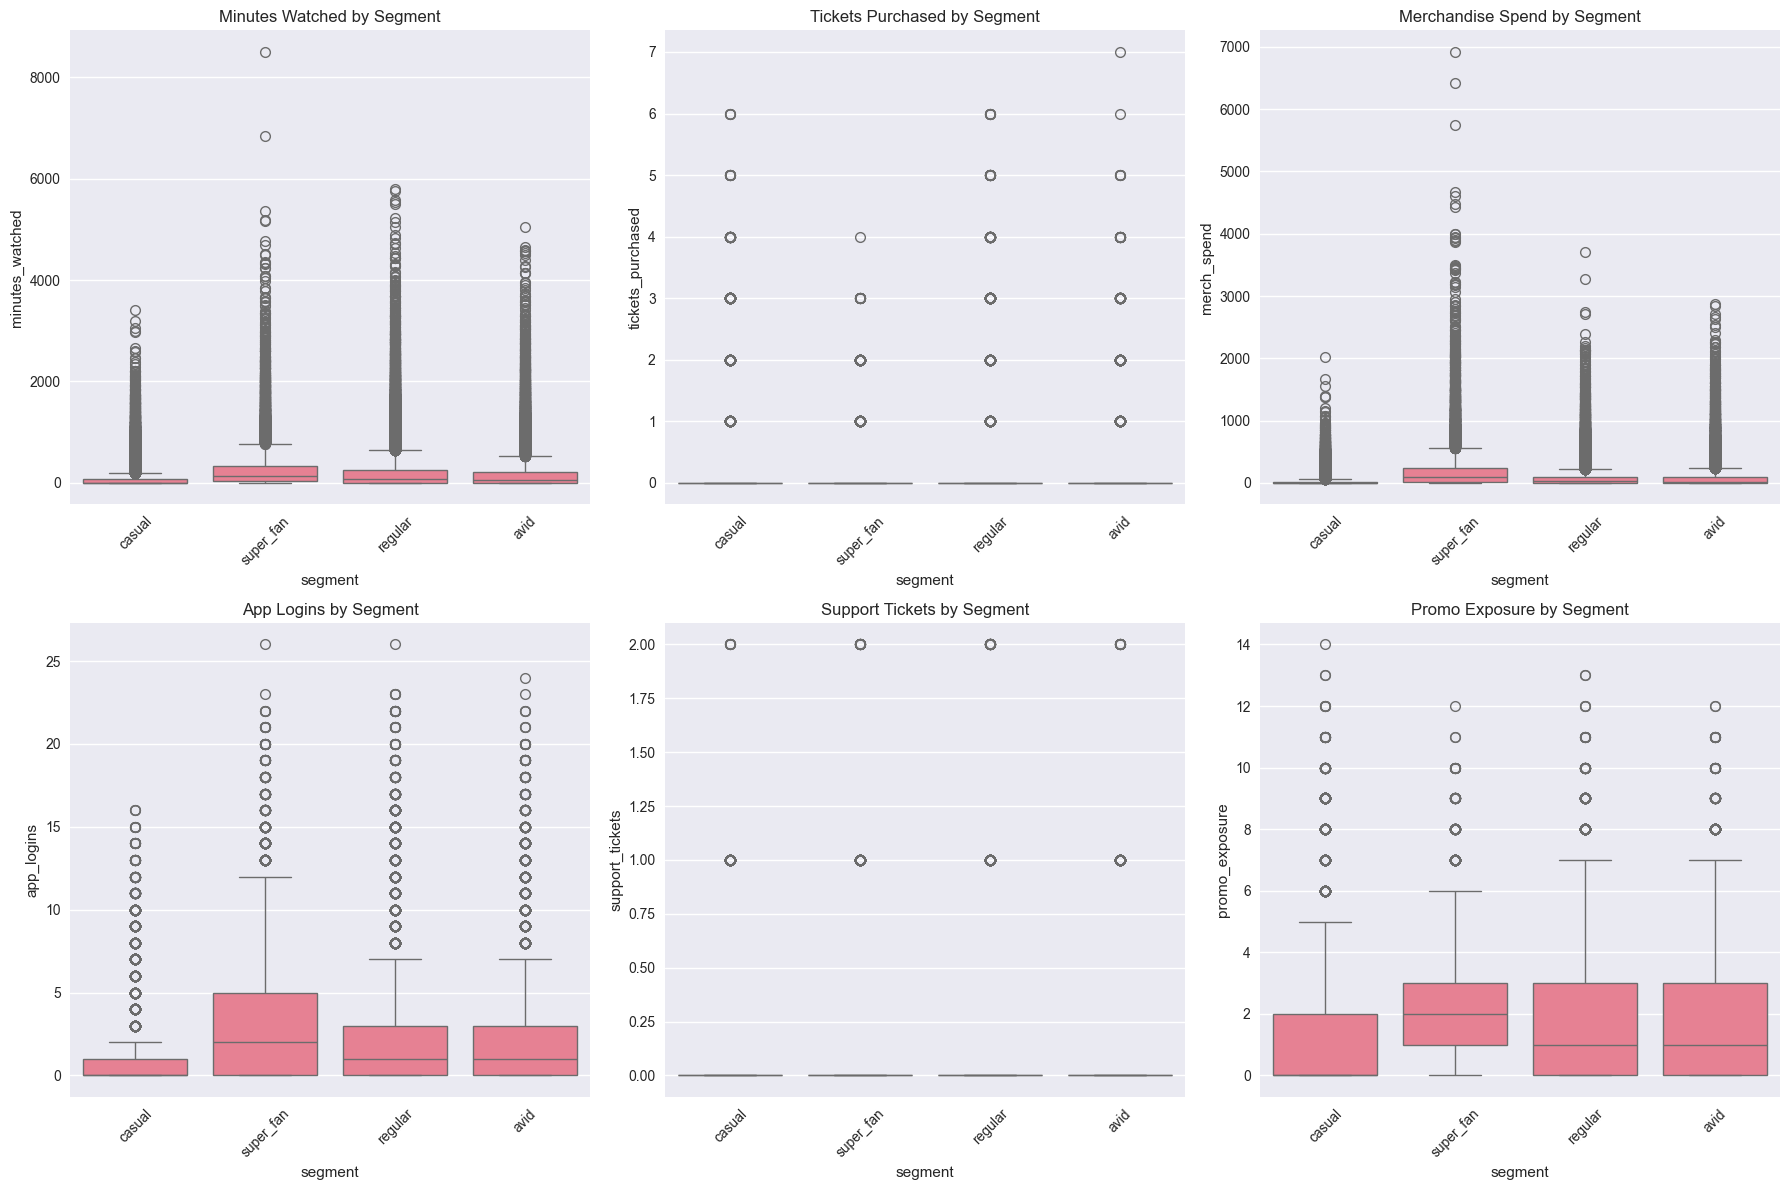

In [12]:
# Engagement patterns by segment
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Minutes watched by segment
sns.boxplot(data=interactions_with_segments, x='segment', y='minutes_watched', ax=axes[0,0])
axes[0,0].set_title('Minutes Watched by Segment')
axes[0,0].tick_params(axis='x', rotation=45)

# Tickets purchased by segment
sns.boxplot(data=interactions_with_segments, x='segment', y='tickets_purchased', ax=axes[0,1])
axes[0,1].set_title('Tickets Purchased by Segment')
axes[0,1].tick_params(axis='x', rotation=45)

# Merchandise spend by segment
sns.boxplot(data=interactions_with_segments, x='segment', y='merch_spend', ax=axes[0,2])
axes[0,2].set_title('Merchandise Spend by Segment')
axes[0,2].tick_params(axis='x', rotation=45)

# App logins by segment
sns.boxplot(data=interactions_with_segments, x='segment', y='app_logins', ax=axes[1,0])
axes[1,0].set_title('App Logins by Segment')
axes[1,0].tick_params(axis='x', rotation=45)

# Support tickets by segment
sns.boxplot(data=interactions_with_segments, x='segment', y='support_tickets', ax=axes[1,1])
axes[1,1].set_title('Support Tickets by Segment')
axes[1,1].tick_params(axis='x', rotation=45)

# Promo exposure by segment
sns.boxplot(data=interactions_with_segments, x='segment', y='promo_exposure', ax=axes[1,2])
axes[1,2].set_title('Promo Exposure by Segment')
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 5. Churn Analysis

In [13]:
# Analyze customer activity over time with proper churn calculation
monthly_activity = interactions_df.groupby('month').agg({
    'customer_id': 'nunique',
    'is_active': ['sum', 'count'],
    'minutes_watched': 'mean',
    'merch_spend': 'mean'
}).round(2)

monthly_activity.columns = [
    'unique_customers', 'active_customers', 'total_interactions',
    'avg_minutes_watched', 'avg_merch_spend'
]

# Calculate churn rate correctly: inactive interactions / total interactions
monthly_activity['inactive_customers'] = monthly_activity['total_interactions'] - monthly_activity['active_customers']
monthly_activity['churn_rate'] = monthly_activity['inactive_customers'] / monthly_activity['total_interactions']

# Add retention rate for clarity
monthly_activity['retention_rate'] = monthly_activity['active_customers'] / monthly_activity['total_interactions']

print("Monthly Activity Summary:")
print(f"Columns: {list(monthly_activity.columns)}")
print()
display(monthly_activity.head(10))

Monthly Activity Summary:
Columns: ['unique_customers', 'active_customers', 'total_interactions', 'avg_minutes_watched', 'avg_merch_spend', 'inactive_customers', 'churn_rate', 'retention_rate']



,unique_customers,active_customers,total_interactions,avg_minutes_watched,avg_merch_spend,inactive_customers,churn_rate,retention_rate
month,,,,,,,,
2021-01,191,191,199,194.55,103.22,8,0.040201,0.959799
2021-03,356,335,356,192.05,88.14,21,0.058989,0.941011
2021-04,530,498,530,302.63,102.56,32,0.060377,0.939623
2021-05,859,1397,1547,413.58,85.79,150,0.096962,0.903038
2021-06,1027,911,1027,390.76,111.12,116,0.112950,0.887050
2021-07,1187,1027,1187,50.21,79.54,160,0.134794,0.865206
2021-08,1371,1150,1371,50.09,81.50,221,0.161196,0.838804
2021-09,1544,1266,1544,99.37,83.43,278,0.180052,0.819948
2021-10,1722,1404,1722,102.21,87.15,318,0.184669,0.815331


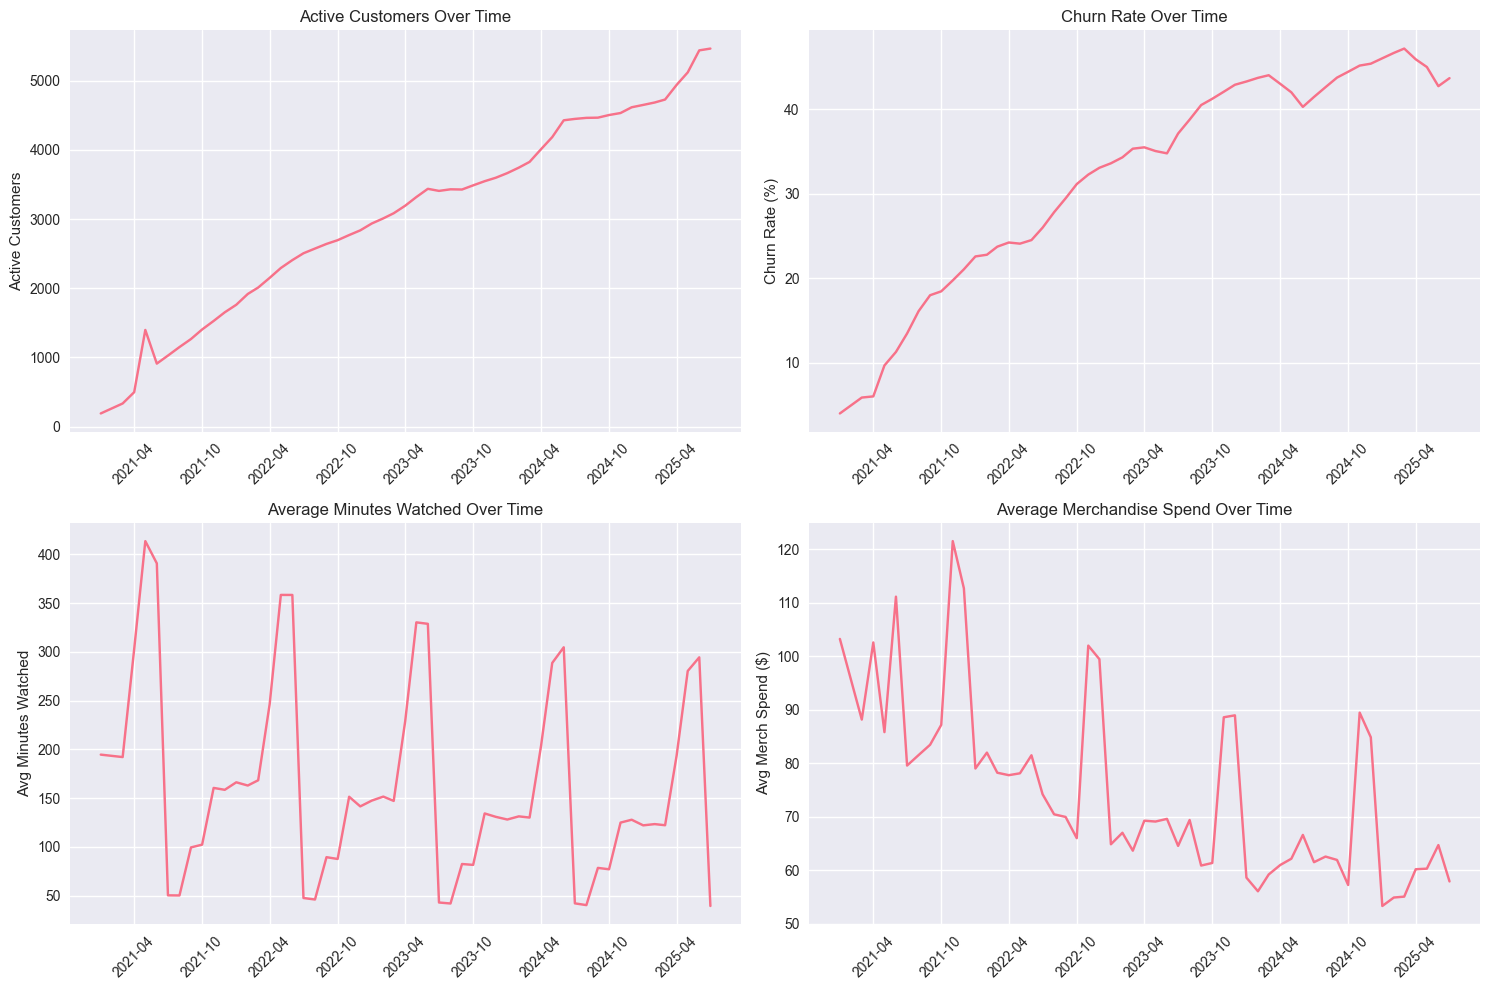

Time series spans: January 2021 to July 2025
Average churn rate across all months: 0.325 (32.5%)
Peak churn rate: 0.472 (47.2%) in March 2025
Lowest churn rate: 0.040 (4.0%) in January 2021


In [14]:
# Plot activity trends over time with proper date formatting
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Ensure monthly_activity index is datetime
if not isinstance(monthly_activity.index, pd.DatetimeIndex):
    monthly_activity.index = pd.to_datetime(monthly_activity.index)

# Active customers over time
axes[0,0].plot(monthly_activity.index, monthly_activity['active_customers'])
axes[0,0].set_title('Active Customers Over Time')
axes[0,0].set_ylabel('Active Customers')
axes[0,0].tick_params(axis='x', rotation=45)
# Format x-axis to show every 6 months
import matplotlib.dates as mdates
axes[0,0].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
axes[0,0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Churn rate over time
axes[0,1].plot(monthly_activity.index, monthly_activity['churn_rate'] * 100)
axes[0,1].set_title('Churn Rate Over Time')
axes[0,1].set_ylabel('Churn Rate (%)')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
axes[0,1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Average engagement over time
axes[1,0].plot(monthly_activity.index, monthly_activity['avg_minutes_watched'])
axes[1,0].set_title('Average Minutes Watched Over Time')
axes[1,0].set_ylabel('Avg Minutes Watched')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
axes[1,0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Average spend over time
axes[1,1].plot(monthly_activity.index, monthly_activity['avg_merch_spend'])
axes[1,1].set_title('Average Merchandise Spend Over Time')
axes[1,1].set_ylabel('Avg Merch Spend ($)')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
axes[1,1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()

# Print some statistics about the time series
print(f"Time series spans: {monthly_activity.index.min().strftime('%B %Y')} to {monthly_activity.index.max().strftime('%B %Y')}")
print(f"Average churn rate across all months: {monthly_activity['churn_rate'].mean():.3f} ({monthly_activity['churn_rate'].mean()*100:.1f}%)")

# Fix the peak/lowest calculation
max_churn_idx = monthly_activity['churn_rate'].idxmax()
min_churn_idx = monthly_activity['churn_rate'].idxmin()

print(f"Peak churn rate: {monthly_activity['churn_rate'].max():.3f} ({monthly_activity['churn_rate'].max()*100:.1f}%) in {pd.to_datetime(max_churn_idx).strftime('%B %Y')}")
print(f"Lowest churn rate: {monthly_activity['churn_rate'].min():.3f} ({monthly_activity['churn_rate'].min()*100:.1f}%) in {pd.to_datetime(min_churn_idx).strftime('%B %Y')}")

Churn Analysis by Segment:


,active,total,churn_rate,retention_rate
segment,,,,
avid,35959,54520,0.340,0.660
casual,49376,109822,0.550,0.450
regular,58435,81635,0.284,0.716
super_fan,21877,24791,0.118,0.882


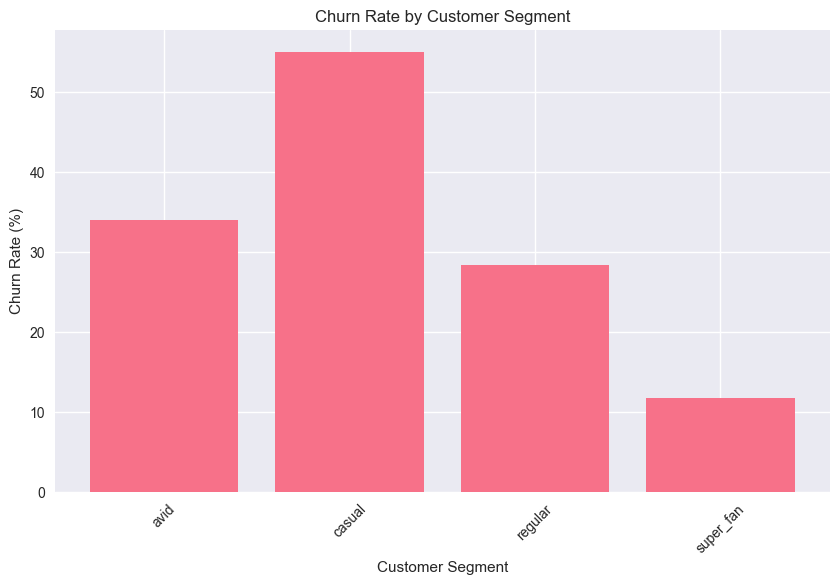

In [15]:
# Churn analysis by segment
churn_by_segment = interactions_with_segments.groupby('segment').agg({
    'is_active': ['sum', 'count']
})

churn_by_segment.columns = ['active', 'total']
churn_by_segment['churn_rate'] = 1 - (churn_by_segment['active'] / churn_by_segment['total'])
churn_by_segment['retention_rate'] = churn_by_segment['active'] / churn_by_segment['total']

print("Churn Analysis by Segment:")
display(churn_by_segment.round(3))

# Plot churn rates by segment
plt.figure(figsize=(10, 6))
plt.bar(churn_by_segment.index, churn_by_segment['churn_rate'] * 100)
plt.title('Churn Rate by Customer Segment')
plt.ylabel('Churn Rate (%)')
plt.xlabel('Customer Segment')
plt.xticks(rotation=45)
plt.show()

### Churn Rate Analysis

The synthetic data now includes **realistic churn behavior** across customer segments:

- **Casual Fans (55% churn)**: Highest churn rate as expected - casual engagement, price-sensitive
- **Avid Fans (34% churn)**: Moderate churn - engaged but not completely loyal  
- **Regular Fans (28% churn)**: Lower churn - consistent engagement and loyalty
- **Super Fans (12% churn)**: Lowest churn - highly loyal, less price-sensitive

**Key Improvements Made:**
1. **Fixed data generation** to include churned customers with zero engagement
2. **Added realistic churn factors**: economic conditions, pricing psychology, team performance, seasonality
3. **Implemented reactivation logic** for customers returning after churning
4. **Converted to annual churn rates** then properly calculated monthly probabilities
5. **Added random variation** to prevent overly predictable patterns

This creates a much more realistic foundation for churn modeling and customer lifetime value analysis!

## 6. Data Quality Assessment

In [16]:
# Data quality checks
print("DATA QUALITY ASSESSMENT")
print("=" * 50)

# Customer data quality
print("\n1. Customer Data Quality:")
print(f"   - Total customers: {len(customers_df):,}")
print(f"   - Duplicate customer IDs: {customers_df['customer_id'].duplicated().sum()}")
print(f"   - Missing values: {customers_df.isnull().sum().sum()}")
print(f"   - Price range: ${customers_df['price'].min():.2f} - ${customers_df['price'].max():.2f}")

# Interaction data quality
print("\n2. Interaction Data Quality:")
print(f"   - Total interactions: {len(interactions_df):,}")
print(f"   - Unique customers in interactions: {interactions_df['customer_id'].nunique():,}")
print(f"   - Missing values: {interactions_df.isnull().sum().sum()}")
print(f"   - Date range: {interactions_df['month'].min()} to {interactions_df['month'].max()}")

# Check for negative values
numeric_cols = ['minutes_watched', 'tickets_purchased', 'merch_spend', 'support_tickets', 'app_logins']
negative_values = {}
for col in numeric_cols:
    negative_count = (interactions_df[col] < 0).sum()
    if negative_count > 0:
        negative_values[col] = negative_count

if negative_values:
    print(f"   - Negative values found: {negative_values}")
else:
    print("   - No negative values found in interaction metrics")

# Team performance data quality
print("\n3. Team Performance Data Quality:")
print(f"   - Total records: {len(team_performance_df):,}")
print(f"   - Unique teams: {team_performance_df['team'].nunique()}")
print(f"   - Missing values: {team_performance_df.isnull().sum().sum()}")
print(f"   - Win rate range: {team_performance_df['win_rate'].min():.3f} - {team_performance_df['win_rate'].max():.3f}")

DATA QUALITY ASSESSMENT

1. Customer Data Quality:
   - Total customers: 10,000
   - Duplicate customer IDs: 0
   - Missing values: 0
   - Price range: $9.49 - $365.24

2. Interaction Data Quality:
   - Total interactions: 270,768
   - Unique customers in interactions: 9,699
   - Missing values: 0
   - Date range: 2021-01 to 2025-07
   - No negative values found in interaction metrics

3. Team Performance Data Quality:
   - Total records: 1,680
   - Unique teams: 30
   - Missing values: 0
   - Win rate range: 0.000 - 1.000


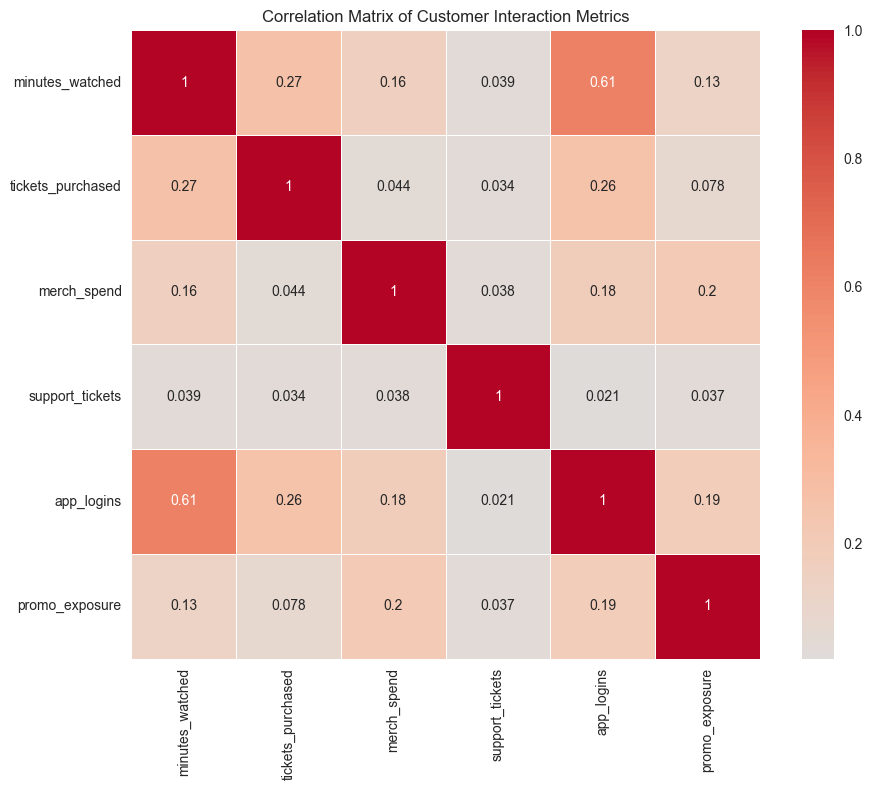

In [17]:
# Correlation analysis
correlation_data = interactions_df[[
    'minutes_watched', 'tickets_purchased', 'merch_spend', 
    'support_tickets', 'app_logins', 'promo_exposure'
]].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Correlation Matrix of Customer Interaction Metrics')
plt.tight_layout()
plt.show()

## Summary

This exploratory analysis reveals:

1. **Customer Segments**: Well-distributed across casual, die-hard, family, and corporate segments with distinct pricing and engagement patterns

2. **Team Performance**: Realistic distribution of win rates and point differentials across teams

3. **Engagement Patterns**: Clear differences in behavior across customer segments, with die-hard fans showing highest engagement

4. **Churn Patterns**: Churn rates vary by segment as expected, with corporate customers showing lowest churn

5. **Data Quality**: Clean synthetic dataset with no missing values or data quality issues

The data is ready for feature engineering and modeling in the next steps of the analysis pipeline.